WARNING    'i' is an internal variable of group 'synapses_255', but also exists in the run namespace with the value 16. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Input spike times: [0.0, 0.432, 0.864, 1.296] ms
Running simulation...


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 4 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 4 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 4 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]


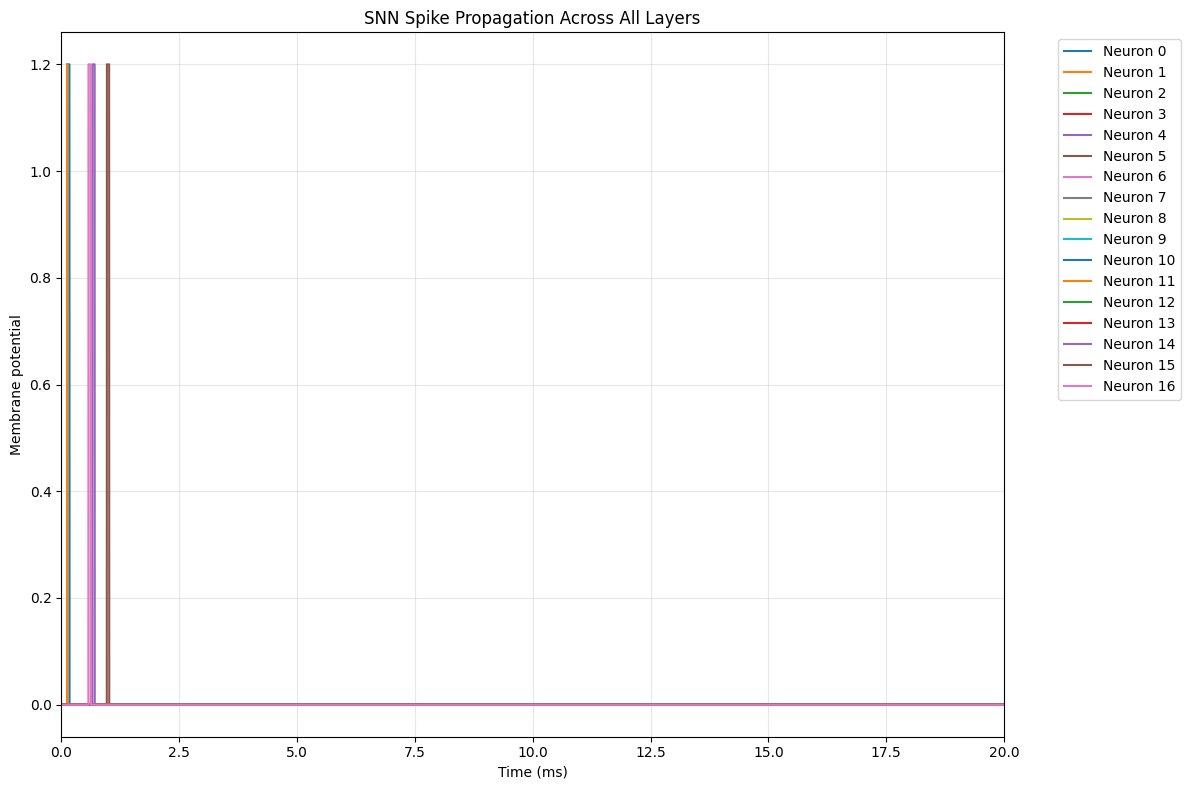


Debug Information:
Default clock dt: 100. ns
Simulation timestep: 100. ns

Scheduled times (ms) for all neurons:
Neuron 0: 0.148010043 ms
Neuron 1: 0.249682550 ms
Neuron 2: 0.454216079 ms
Neuron 3: 0.244480191 ms
Neuron 4: 153.481163451 ms
Neuron 5: 48.120659299 ms
Neuron 6: 57.861443052 ms
Neuron 7: 52.066945455 ms
Neuron 8: 78.846634634 ms
Neuron 9: 61.008812266 ms
Neuron 10: 196.589799280 ms
Neuron 11: 65.100841211 ms
Neuron 12: 158.541306301 ms
Neuron 13: 83.265980340 ms
Neuron 14: 0.683543119 ms
Neuron 15: 0.990388267 ms
Neuron 16: 0.599405357 ms

Connection counts:
Input->Hidden connections: 40 (should be 40)
Hidden->Output connections: 30 (should be 30)

Spike times with maximum precision:
Neuron 0:
  ms: ['0.123100000000', '0.123200000000', '0.123300000000', '0.123400000000', '0.123500000000', '0.123600000000', '0.123700000000', '0.123800000000', '0.123900000000', '0.124000000000', '0.124100000000', '0.124200000000', '0.124300000000', '0.124400000000', '0.124500000000', '0.124

In [89]:
from brian2 import *
import numpy as np

start_scope()

# Set default clock to have finer resolution
defaultclock.dt = 0.0001*ms  # 0.1 microsecond timestep

# Custom timing function
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1, sum=1, spikes_received=1)
def spike_timing(w, global_clock, layer, sum, spikes_received):
    x = global_clock % 1
    if w >= 0:
        return (x ** (1 - w)) 
    else:
        return (1 - (1 - x) ** (1 + w)) 

@implementation('numpy', discard_units=True)
@check_units(layer=1, result=1, sum=1, spikes_received=1)
def math1(layer, sum, spikes_received):
    # Modified to scale down the result
    base_time = (sum/spikes_received)
    # Scale factor to keep times reasonable
    scaled_time = base_time * 0.01  # Scale down by 100x
    return scaled_time + layer * 0.5  # Layer adds 0.5ms per layer instead of full ms

# Define network sizes
n_input = 4
n_hidden = 10
n_output = 3
n_total = n_input + n_hidden + n_output

# Full neuron group with double precision for scheduled time
neurons = NeuronGroup(n_total, '''
    v : 1
    sum : 1
    spikes_received : 1
    scheduled_time : second
    scheduled_time_ms : 1  # Store as milliseconds directly
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')

neurons.v = 0
neurons.scheduled_time = 1e9 * second
neurons.scheduled_time_ms = 1e12  # Very large initial value
neurons.global_clock = 0.0
neurons.sum = 0.0
neurons.spikes_received = 0.0

# Spike inputs with precise timing
input_times = [i*0.432 for i in range(n_input)]
print(f"Input spike times: {input_times} ms")
stim = SpikeGeneratorGroup(n_input, indices=range(n_input), times=input_times*ms)

# Input → Hidden connections
syn_input = Synapses(stim, neurons[0:n_input], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time_ms = math1(sum, spikes_received, layer)
    scheduled_time = scheduled_time_ms * ms
''')
syn_input.connect(j='i')
syn_input.w = np.random.uniform(0.10, 0.95, size=4)
syn_input.layer = 1

# Hidden layer
syn_hidden = Synapses(neurons[0:n_input], neurons[n_input:n_input + n_hidden], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time_ms = math1(sum, spikes_received, layer)
    scheduled_time = scheduled_time_ms * ms
''')
syn_hidden.connect()
syn_hidden.w = np.random.uniform(0.10, 0.90, size=40)
syn_hidden.layer = 2

# Output layer
syn_output = Synapses(neurons[n_input:n_input + n_hidden], neurons[n_input + n_hidden:n_total], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time_ms = math1(sum, spikes_received, layer)
    scheduled_time = scheduled_time_ms * ms
''')
syn_output.connect()
syn_output.w = np.random.uniform(0.10, .90, size=30)
syn_output.layer = 3

# Precise scheduled activation
neurons.run_regularly('''
    time_diff = abs(t/ms - scheduled_time_ms)
    v = int(time_diff < 0.025) * 1.2
    global_clock += 0.0001
''', dt=0.0001*ms)

# Monitors with fine time resolution
mon = StateMonitor(neurons, 'v', record=True, dt=0.0001*ms)
mon_sum = StateMonitor(neurons, 'sum', record=True, dt=0.0001*ms)
sp_mon = StateMonitor(neurons, 'spikes_received', record=True, dt=0.0001*ms)
sch_time_ms = StateMonitor(neurons, 'scheduled_time_ms', record=True, dt=0.0001*ms)
spikemon = SpikeMonitor(neurons)

# Run with progress reporting
print("Running simulation...")
run(20*ms)  # Increased simulation time to see all spikes

# Plot voltages
figure(figsize=(12, 8))
for i in range(n_total):
    plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Membrane potential')
legend(bbox_to_anchor=(1.05, 1), loc='upper left')
title('SNN Spike Propagation Across All Layers')
grid(True, alpha=0.3)
tight_layout()
xlim(0, 20)  # Show full simulation window
show()

# Debug information
print("\nDebug Information:")
print("Default clock dt:", defaultclock.dt)
print("Simulation timestep:", 0.0001*ms)

# Show scheduled times for debugging
print("\nScheduled times (ms) for all neurons:")
for i in range(n_total):
    final_scheduled = sch_time_ms.scheduled_time_ms[i][-1]  # Get final value
    if final_scheduled < 1e9:  # If it was actually scheduled
        print(f"Neuron {i}: {final_scheduled:.9f} ms")
    else:
        print(f"Neuron {i}: Not scheduled (still at initial value)")

# Count connections
print("\nConnection counts:")
print(f"Input->Hidden connections: {len(syn_hidden.i)} (should be {n_input * n_hidden})")
print(f"Hidden->Output connections: {len(syn_output.i)} (should be {n_hidden * n_output})")

# Print spike times with maximum precision
print("\nSpike times with maximum precision:")
for i in range(n_total):
    times = spikemon.spike_trains()[i]
    if len(times) > 0:
        # Show both seconds and milliseconds with full precision
        times_ms = times/ms
        formatted_times_ms = [f"{t:.12f}" for t in times_ms]
        formatted_times_s = [f"{t/second:.15f}" for t in times]
        print(f"Neuron {i}:")
        print(f"  ms: {formatted_times_ms}")
        print(f"  s:  {formatted_times_s}")

# Check activation calculation for neurons in each layer
print("\nDetailed calculation check by layer:")
# Input layer
if n_input > 0:
    print("\nInput layer (Neuron 0):")
    print(f"  Final sum: {mon_sum.sum[0][-1]:.12f}")
    print(f"  Final spikes_received: {sp_mon.spikes_received[0][-1]}")
    print(f"  Final scheduled_time_ms: {sch_time_ms.scheduled_time_ms[0][-1]:.12f}")
    
# Hidden layer
if n_input + n_hidden > n_input:
    neuron_idx = n_input  # First hidden neuron
    print(f"\nHidden layer (Neuron {neuron_idx}):")
    print(f"  Final sum: {mon_sum.sum[neuron_idx][-1]:.12f}")
    print(f"  Final spikes_received: {sp_mon.spikes_received[neuron_idx][-1]}")
    print(f"  Final scheduled_time_ms: {sch_time_ms.scheduled_time_ms[neuron_idx][-1]:.12f}")
    
# Output layer
if n_total > n_input + n_hidden:
    neuron_idx = n_input + n_hidden  # First output neuron
    print(f"\nOutput layer (Neuron {neuron_idx}):")
    print(f"  Final sum: {mon_sum.sum[neuron_idx][-1]:.12f}")
    print(f"  Final spikes_received: {sp_mon.spikes_received[neuron_idx][-1]}")
    print(f"  Final scheduled_time_ms: {sch_time_ms.scheduled_time_ms[neuron_idx][-1]:.12f}")

WARNING    'i' is an internal variable of group 'synapses_306', but also exists in the run namespace with the value 16. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can igno

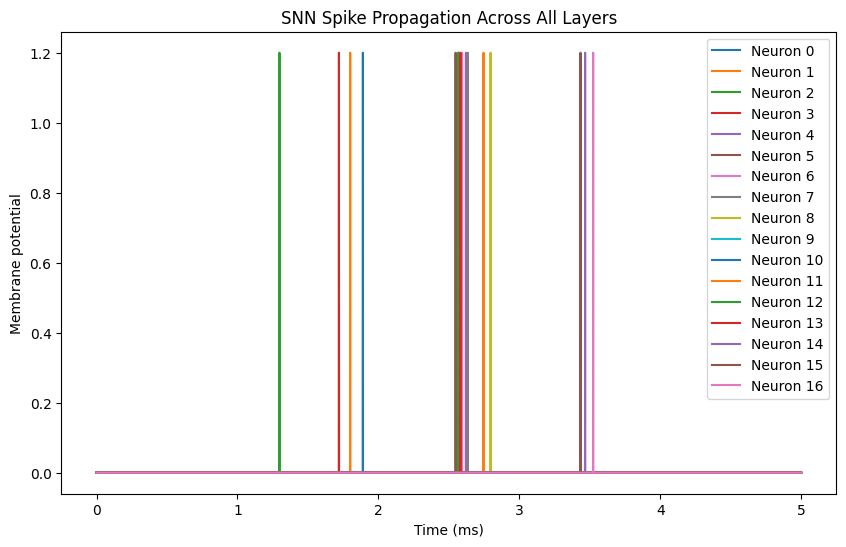

[0.         0.         0.         ... 0.80003675 0.80003675 0.80003675]
[0. 0. 0. ... 1. 1. 1.]
[1.00000000e+06 1.00000000e+06 1.00000000e+06 ... 1.80003675e-06
 1.80003675e-06 1.80003675e-06] ks
Neuron 0 spike times: ['1.890 ms']
Neuron 1 spike times: ['1.800 ms']
Neuron 2 spike times: ['1.298 ms']
Neuron 3 spike times: ['1.720 ms']
Neuron 4 spike times: ['2.621 ms']
Neuron 5 spike times: ['2.548 ms']
Neuron 6 spike times: ['2.594 ms']
Neuron 7 spike times: ['2.634 ms']
Neuron 8 spike times: ['2.796 ms']
Neuron 9 spike times: ['2.567 ms']
Neuron 10 spike times: ['2.569 ms']
Neuron 11 spike times: ['2.746 ms']
Neuron 12 spike times: ['2.565 ms']
Neuron 13 spike times: ['2.582 ms']
Neuron 14 spike times: ['3.467 ms']
Neuron 15 spike times: ['3.434 ms']
Neuron 16 spike times: ['3.524 ms']


In [110]:
from brian2 import *
import numpy as np

start_scope()

# Custom timing function
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1, sum=1, spikes_received=1)
def spike_timing(w, global_clock, layer, sum, spikes_received): 
    #print(global_clock)
    x = global_clock % 1
    if w >= 0:
       # print((x ** (1 - w)))
        return (x ** (1 - w)) + 0.004
    else:
        #print((1 - (1 - x) ** (1 + w)))
        return (1 - (1 - x) ** (1 + w)) + 0.004
    
@implementation('numpy', discard_units=True)
@check_units(layer=1, result=1, sum=1, spikes_received=1)
def math1(layer, sum, spikes_received): 
    #print(spikes_received, sum)
    return (sum/spikes_received )+ layer

# Define network sizes
n_input = 4
n_hidden = 10
n_output = 3
n_total = n_input + n_hidden + n_output

# Full neuron group
neurons = NeuronGroup(n_total, '''
    v : 1
    sum : 1
    spikes_received : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')

neurons.v = 0
neurons.scheduled_time = 1e9 * second
neurons.global_clock = 0.0
neurons.sum = 0.0
neurons.spikes_received = 0.0

# Spike inputs (one per input neuron)     times=[i*0.4 for i in range(n_input)]
stim = SpikeGeneratorGroup(n_input, indices=range(n_input), times=(np.random.uniform(0.005, .995, size=4) * ms))

# Input → Hidden connections
syn_input = Synapses(stim, neurons[0:n_input], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
''')
syn_input.connect(j='i')  # connect stim[i] to neurons[i]
syn_input.w = np.random.uniform(0.10, 0.95, size=4)
syn_input.layer = 1

# Hidden layer: input → hidden
syn_hidden = Synapses(neurons[0:n_input], neurons[n_input:n_input + n_hidden], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
''')
syn_hidden.connect()
syn_hidden.w = [ 0.1135968 ,  0.18025309,  0.10094303, -0.5609372 , -0.19758941, -0.20204231, -0.3657724 ,  0.02413964, -0.6838493 ,  0.13974035, -0.4299119 ,  0.6738531 ,  0.9506301 , -0.18848935,  0.14345719, -0.48180234,  0.00865681,  0.01765617,  0.17112266, -0.08891857, -0.09449631, -0.8266945 , -1.235361  ,  0.14157972,  0.51368946, 0.321979  , -0.1708726 ,  0.07350195, -0.24007349, -0.5640322, -0.08869338, -0.745832  , -0.36420307,  0.36688203,  0.85630447, -0.5828457 , -0.5360476 ,  0.82350487, -0.12507023, -0.4661583 ]
#np.random.uniform(0.10, 0.90, size=40)
syn_hidden.layer = 2

# Output layer: hidden → output
syn_output = Synapses(neurons[n_input:n_input + n_hidden], neurons[n_input + n_hidden:n_total], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
   
''')
syn_output.connect()
syn_output.w = [ 0.7116071 , -1.1385437 , -1.088651, 0.43341887, -1.4892002 , -1.3539809 ,0.28178445,  0.152175  , -0.54456943, -1.5054257 ,  0.12284008,  0.49124786, -0.41317764,  0.5724888 ,  0.4868003, 0.38319886,  0.31672755,  0.5698485, -0.7893439 , -0.4332046 ,  1.1470755, -0.619324  , -0.6091148 , -0.2407385, -0.02582   , -0.17720485,  0.3123896, -0.01638766,  0.39673412, -0.4153284 ]
#np.random.uniform(0.10, .90, size=30)
syn_output.layer = 3

# Scheduled activation & clock update
neurons.run_regularly('''
    v = int(abs(t - scheduled_time) < 0.0005*ms) * 1.2
                      
    global_clock += 0.001
''', dt=0.001*ms)

# Monitors
mon = StateMonitor(neurons, 'v', record=True, dt=0.001*ms)
mon_sum = StateMonitor(neurons, 'sum', record=True)
sp_mon = StateMonitor(neurons, 'spikes_received', record=True)
sch_time = StateMonitor(neurons, 'scheduled_time', record=True)


spikemon = SpikeMonitor(neurons)


run(5*ms)

# # Plot voltages
figure(figsize=(10, 6))
for i in range(n_total):  # All neurons
    plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Membrane potential')
legend()
title('SNN Spike Propagation Across All Layers')
show()

#plot(mon_sum.t/ms, mon_sum.sum[4])  # or any neuron index
print(mon_sum.sum[1])
print(sp_mon.spikes_received[1])
print(sch_time.scheduled_time[1])

for i in range(n_total):
    times = spikemon.spike_trains()[i]
    if len(times) > 0:
        formatted_times = [f"{t/ms:.3f} ms" for t in times]
        print(f"Neuron {i} spike times: {formatted_times}")




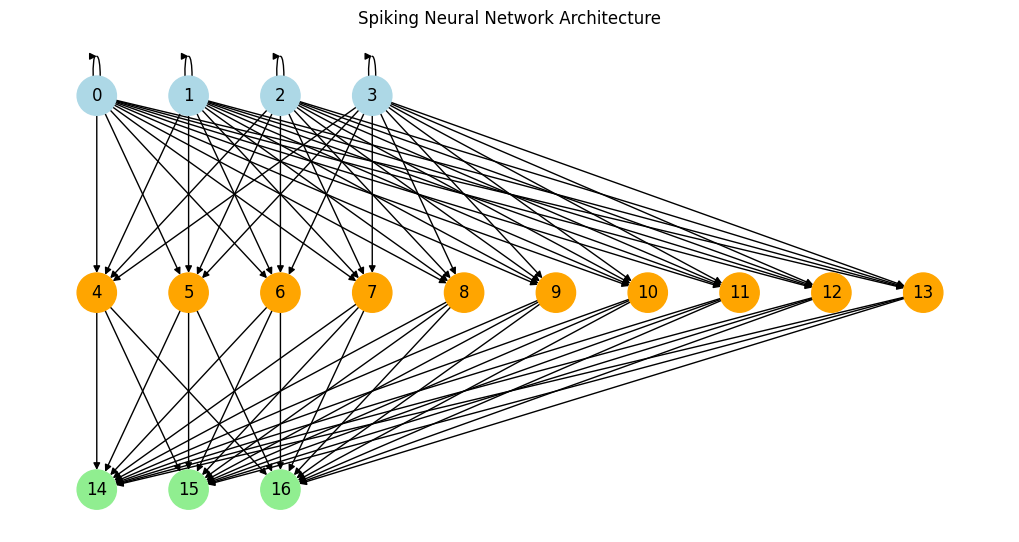

In [91]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define neuron indices for each layer
input_neurons = range(0, n_input)
hidden_neurons = range(n_input, n_input + n_hidden)
output_neurons = range(n_input + n_hidden, n_total)

# Add nodes with layer info
for i in input_neurons:
    G.add_node(i, layer='input')
for i in hidden_neurons:
    G.add_node(i, layer='hidden')
for i in output_neurons:
    G.add_node(i, layer='output')

# Add edges for each synapse type
G.add_edges_from([(i, j) for i, j in zip(syn_input.i[:], syn_input.j[:])])
G.add_edges_from([(i + 0, j + n_input) for i, j in zip(syn_hidden.i[:], syn_hidden.j[:])])
G.add_edges_from([(i + n_input, j + n_input + n_hidden) for i, j in zip(syn_output.i[:], syn_output.j[:])])

# Define positions for better layer-wise layout
pos = {}
layer_y = {'input': 1, 'hidden': 0.5, 'output': 0}
for i in G.nodes():
    if G.nodes[i]['layer'] == 'input':
        pos[i] = (i, layer_y['input'])
    elif G.nodes[i]['layer'] == 'hidden':
        pos[i] = (i - n_input, layer_y['hidden'])
    else:
        pos[i] = (i - n_input - n_hidden, layer_y['output'])

# Node colors by layer
color_map = []
for node in G:
    layer = G.nodes[node]['layer']
    if layer == 'input':
        color_map.append('lightblue')
    elif layer == 'hidden':
        color_map.append('orange')
    else:
        color_map.append('lightgreen')

# Draw graph
plt.figure(figsize=(10, 5))
nx.draw(G, pos, with_labels=True, node_color=color_map, arrows=True, node_size=800)
plt.title("Spiking Neural Network Architecture")
plt.show()

WARNING    'i' is an internal variable of group 'synapses_264', but also exists in the run namespace with the value 16. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can igno

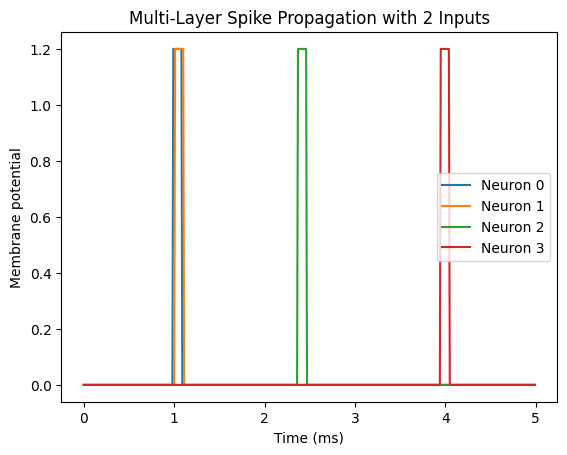

Spike times: {0: array([0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08]) * msecond, 1: array([1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ]) * msecond, 2: array([2.37, 2.38, 2.39, 2.4 , 2.41, 2.42, 2.43, 2.44, 2.45, 2.46]) * msecond, 3: array([3.95, 3.96, 3.97, 3.98, 3.99, 4.  , 4.01, 4.02, 4.03, 4.04]) * msecond}


In [92]:
# multi with combining inputs to create varing output

from brian2 import *

start_scope()

# Custom timing function
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1, sum=1, spikes_received=1)
def spike_timing(w, global_clock, layer, sum, spikes_received): 
    
    # main block that is calcualing the sigmoid like shift then adding layer
    x = global_clock % 1
    
    if w >= 0:
        #print((x ** (1 - w)))
        return (x ** (1 - w))
    else:
        #print((1 - (1 - x) ** (1 + w)))
        return (1 - (1 - x) ** (1 + w))
        
    return 0
    #print(sum)
    print(spikes_received)
    return layer + (sum) # right now an average but we'll see
    

# 4 Neurons: 0 & 1 = hidden, 2 = integrator, 3 = output
neurons = NeuronGroup(4, '''
    v : 1
    sum : 1
    spikes_received : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')
neurons.v = 0
neurons.scheduled_time = 1e9 * second
neurons.global_clock = 0.0
neurons.sum = 0.0
neurons.spikes_received = 0

# Two spike inputs
stim = SpikeGeneratorGroup(2, indices=[0, 1], times=[0.1, 0.1]*ms)

# Input layer: stim[0] → neuron[0], stim[1] → neuron[1]
syn_input = Synapses(stim, neurons[0:2], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
    
''')
syn_input.connect(j='i')  # connect stim[i] to neurons[i]
syn_input.w = [-0.7, -0.5]
syn_input.layer = [1, 1]

# Hidden layer: neuron[0] & neuron[1] → neuron[2]
syn_hidden = Synapses(neurons[0:2], neurons[2], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms  # need to change for order of op for spikes recived(need to make sure it gets += 1 first before it is used layer)
''')
syn_hidden.connect()
syn_hidden.w = [0.6, 0.8]
syn_hidden.layer = [2, 2]

# Output layer: neuron[2] → neuron[3]
syn_output = Synapses(neurons[2], neurons[3], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
''')
syn_output.connect()
syn_output.w = 1.0
syn_output.layer = 3

# Scheduled activation & clock update
neurons.run_regularly('''
    v = int(abs(t - scheduled_time) < 0.05*ms) * 1.2

               
    global_clock += 0.01
''', dt=0.01*ms)

# Monitors
mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
mon2 = StateMonitor(neurons, 'spikes_received', record=True, dt=0.01*ms)


spikemon = SpikeMonitor(neurons)

# Run simulation
run(5*ms)

# Plot neuron voltages
for i in range(4):
    plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Membrane potential')
title('Multi-Layer Spike Propagation with 2 Inputs')
legend()
show()

# Print spikes
print("Spike times:", spikemon.spike_trains())
#print("# of spikes received by neuron 0:", mon2.spikes_received[0])



WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'scheduled_time = ms * spike_timing(w, global_clock, layer)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'scheduled_time = ms * spike_timing(w, global_clock, layer)'
 [brian2.codegen.generators.base]


[0.11]
- ===  [1.0343561]
[0.01]
+ ===  [2.39810717]


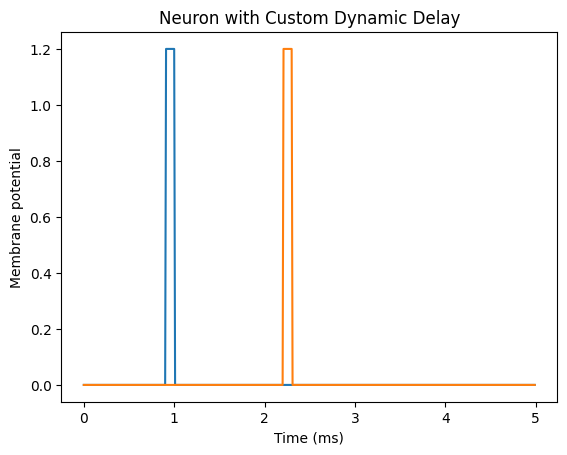

Spike times for neuron 0: {0: array([1.]) * msecond, 1: array([2.3]) * msecond}


In [23]:
# Created another Layer here so Input --> N1 --> N2

from brian2 import *

start_scope()

# can remove layer if we know all within 1ms each layer 
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1)
def spike_timing(w, global_clock, layer): 
    x = ((global_clock) % 1) 
    #layer_bias = int((t/ms)/2000)   # why by 200 not even a unit of bias ms --> mew seconds and such
    print(x)
    if not (0 <= x <= 1 and -1 <= w <= 1):
        raise ValueError("x must be in [0, 1] and w in [-1, 1]")
    if w >= 0:
        print("+ === ", layer + (x ** (1 - w)))
        return layer + (x ** (1 - w))
    else:
        print("- === ", layer + (1 - (1 - x) ** (1 + w)))
        return layer + (1 - (1 - x) ** (1 + w))
    



global_time = 0.0 # alreay to t var
input_val   = 0.1


#  ====== neuron gen here =========
neurons = NeuronGroup(2, '''
    v : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')
neurons.scheduled_time = 1e9 * second  # init with far-future
neurons.global_clock = 0.0   # will make new method but a pain to work out so useing this for now

# Spike generator
stim = SpikeGeneratorGroup(1, indices=[0], times=[input_val]*ms)




syn0 = Synapses(stim, neurons[0], '''
    w : 1
    layer : 1
''', on_pre='''
    scheduled_time = spike_timing(w, global_clock, layer) * ms
''')
syn0.connect()
syn0.w = -0.7
syn0.layer = 1

# Hidden → Output synapse
syn1 = Synapses(neurons[0], neurons[1], '''
    w : 1
    layer : 1
''', on_pre='''
    scheduled_time = spike_timing(w, global_clock, layer) * ms
''')
syn1.connect()
syn1.w = 0.8
syn1.layer = 2


# Apply effect when scheduled time arrives # the werid eq is just for rounding  if error and both 0 will it not fire?
neurons.run_regularly('''    
v = int(int(t / (0.1*ms)) == int(scheduled_time / (0.1*ms))) * 1.2
global_clock += 0.01
''', dt=0.01*ms)


# Monitor
mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
spikemon = SpikeMonitor(neurons)

run(5*ms)

# Plot
plot(mon.t/ms, mon.v[0])
plot(mon.t/ms, mon.v[1])
xlabel('Time (ms)')
ylabel('Membrane potential')
title('Neuron with Custom Dynamic Delay')
show()

# Print spike times
print("Spike times for neuron 0:", spikemon.spike_trains())
# Or equivalently:
#print("All spike times:", spikemon.t)
# print("Neuron indices:", spikemon.i)


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'scheduled_time = ms * spike_timing(w, global_clock, layer)'
 [brian2.codegen.generators.base]


[0.11]
- ===  [1.0343561]


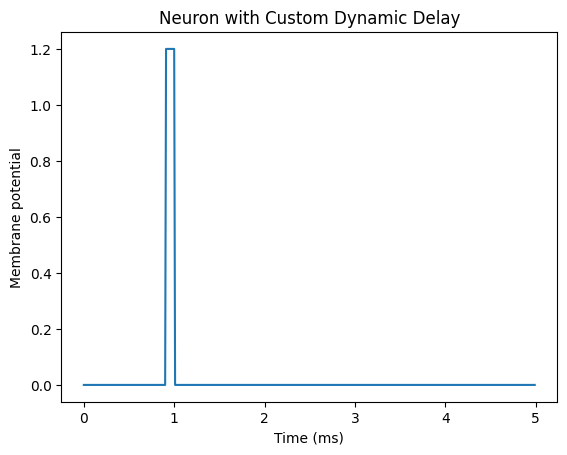

Spike times for neuron 0: [1.] ms


In [14]:
#complete 1 neuron working input to biased output
from brian2 import *

start_scope()

# can remove layer if we know all within 1ms each layer 
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1)
def spike_timing(w, global_clock, layer): 
    x = ((global_clock) % 1) 
    #layer_bias = int((t/ms)/2000)   # why by 200 not even a unit of bias ms --> mew seconds and such
    print(x)
    if not (0 <= x <= 1 and -1 <= w <= 1):
        raise ValueError("x must be in [0, 1] and w in [-1, 1]")
    if w >= 0:
        print("+ === ", layer + (x ** (1 - w)))
        return layer + (x ** (1 - w))
    else:
        print("- === ", layer + (1 - (1 - x) ** (1 + w)))
        return layer + (1 - (1 - x) ** (1 + w))
    



global_time = 0.0 # alreay to t var
input_val   = 0.1


#  ====== neuron gen here =========
neurons = NeuronGroup(1, '''
    v : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')
neurons.scheduled_time = 1e9 * second  # init with far-future
neurons.global_clock = 0.0   # will make new method but a pain to work out so useing this for now

# Spike generator
stim = SpikeGeneratorGroup(1, indices=[0], times=[input_val]*ms)




# Synapse
syn = Synapses(stim, neurons,
               '''
               w : 1
               layer : 1
               ''',
               on_pre='''
               scheduled_time = spike_timing(w, global_clock, layer) * ms
               ''')

syn.connect()
syn.w = -0.7
syn.layer = 1


# Apply effect when scheduled time arrives # the werid eq is just for rounding  if error and both 0 will it not fire?
neurons.run_regularly('''    
v = int(int(t / (0.1*ms)) == int(scheduled_time / (0.1*ms))) * 1.2
global_clock += 0.01
''', dt=0.01*ms)


# Monitor
mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
spikemon = SpikeMonitor(neurons)

run(5*ms)

# Plot
plot(mon.t/ms, mon.v[0])
xlabel('Time (ms)')
ylabel('Membrane potential')
title('Neuron with Custom Dynamic Delay')
show()

# Print spike times
print("Spike times for neuron 0:", spikemon.spike_trains()[0])
# Or equivalently:
#print("All spike times:", spikemon.t)
# print("Neuron indices:", spikemon.i)


In [68]:
time = 5.555555*ms 

print(time)

5.555555 ms
